# Develop Fan Chart Vis
Trying to produce a nice fan chart visualization to compare the magnitude of variability between systems, relative to the mean value in particular.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
EBU = 'CalCS'
VAR = 'FG_CO2'
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
ds = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')

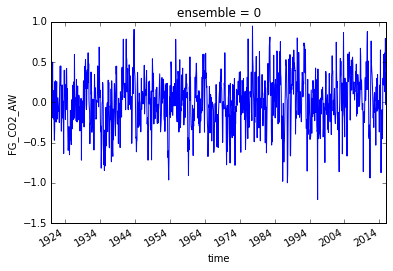

In [14]:
ds['FG_CO2_AW'][0].plot()